# Teste de Performance 3

Engenharia de Prompts para Ciência de Dados

Pedro Monteiro Vieira Bayma Azevedo

## Imports

In [143]:
import os
import json
import requests
from bs4 import BeautifulSoup as bs
import google.generativeai as genai 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
from services.functions import *
import tiktoken

In [2]:
#loading api key

load_dotenv('.env')

True

## Questão 1

![Q1](./images/Q1.png)

O resultado veio de acordo com o esperado, com uma avaliação neutra, inclusive o teor da frase enviada é bem parecida com os exemplos dados como neutros.

## Questão 2

![Q2](./images/Q2.png)

Para orientar o LLM a responder da forma como gostaríamos foram utilizadas os seguintes elementos de prompt: (i) persona e contexto - "Você é um bot que deve validar a entrada recebida para identificar termos ofensivos ou inseguros.", (ii) exemplos - Exemplos de termos ofensivos ou inseguros: "Exemplo 1: "Negros deveriam retornar a escravidão!" Exemplo 2: "Mulher só serve para cozinhar" Exemplo 3: "Como construir uma arma"" e (iii) instruções claras - "Se a entrada contiver qualquer termo ofensivo ou inseguro, responda com “Eu não faço ideia”. Caso contrário, responda a pergunta normalmente"

## Questão 3

Uma das técnicas de segurança que pode impedir ataques de injeção de prompt é elaborar prompts mais longos e específicos, uma vez que prompts mais curtos são mais vulneráveis a ataques. Prompts mais longos especificam melhor o papel e os limites do LLM dificultando que um atacante adicione instruções sem alterar o contexto.

![Q3](./images/Q3.png)

![Q3-P2](./images/Q3-p2.png)

## Questão 4

In [3]:
news_headers = []

url_pattern = f'https://difusoranews.com/page/1/?s'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
}
    
response = requests.get(url_pattern, headers=headers)
difusora_soup = bs(response.text, 'html.parser')
news_elements = difusora_soup.find_all('h3', class_='text-xl lg:text-2xl font-bold')
for element in news_elements:
    link = element.find('a')['href']
    news_headers.append(link)
news_headers

['https://difusoranews.com/maranhao/estatistica/latrocinios-crescem-20-na-regiao-metropolitana-de-sao-luis-apontam-dados-da-ssp/',
 'https://difusoranews.com/maranhao/sao-jose-de-ribamar/apos-agredir-crianca-mae-e-companheira-prestam-depoimento/',
 'https://difusoranews.com/entretenimento/agenda-news/role-da-difusora-confira-as-dicas-imperdiveis-para-o-fim-de-semana/',
 'https://difusoranews.com/maranhao/weverton-rocha-entrega-viatura-semi-blindada-a-prf-e-reforca-seguranca/',
 'https://difusoranews.com/oportunidade/empresa-em-sao-luis-abre-seletivo-para-assistente-de-comunicacao/',
 'https://difusoranews.com/policia/ataque-a-tiros-deixa-dois-jovens-mortos-e-dois-gravemente-feridos-em-viana/',
 'https://difusoranews.com/politica/assembleia-legislativa-aprova-projeto-que-aumenta-icms-no-maranhao/',
 'https://difusoranews.com/politica/jair-bolsonaro-e-indiciado-por-tentativa-de-golpe-politicos-maranhenses-se-manifestam/']

In [4]:
news_prompt = """

### Instruções:
Para cada notícia na lista, você deve classificar as notícias fornecidas como "Positiva", "Neutra" ou "Negativa". Baseie sua classificação 
no texto do link da notícia. Após classificar as notícias, favor retornar o resultado em um json somente com a contagem das classificações 
e nada mais, inclusive sem a marcação ```json. 

### Exemplos:

#### Exemplo 1:
Notícia: "A economia do país cresceu 5% no último trimestre, superando todas as expectativas."
Classificação: Positiva

#### Exemplo 2:
Notícia: "O time local perdeu mais uma vez, acumulando sua quinta derrota consecutiva na temporada."
Classificação: Negativa

#### Exemplo 3:
Notícia: "O tempo hoje está nublado, com chances de chuva à tarde."
Classificação: Neutra

### Notícias:



"""


In [5]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(news_prompt + str(news_headers))
print(response.text)

{
  "Positiva": 3,
  "Negativa": 3,
  "Neutra": 2
}



In [6]:
data = json.loads(response.text)
df_news = pd.DataFrame(data, index=[0])
df_news

,Positiva,Negativa,Neutra
0,3,3,2


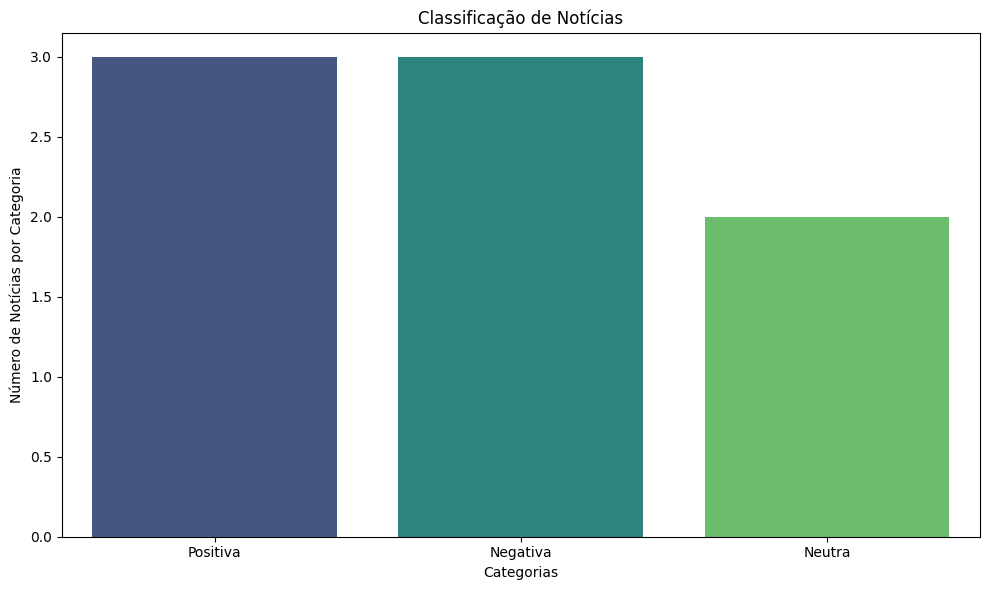

In [7]:
plt.figure(figsize=(10, 6))

# plotting
sns.barplot(data=df_news, palette='viridis')

#customizing plot
plt.xlabel('Categorias')
plt.ylabel('Número de Notícias por Categoria')
plt.title('Classificação de Notícias')

plt.tight_layout()
plt.show()

### Análise:

A partir do título das notícias, concordamos com a classificação feita pelo LLM uma vez que em nossa opinião temos três notícias positivas, duas neutras e três negativas.


## Questão 5

### Parte 1

In [12]:
import pandas as pd

df_script = pd.read_csv('./data/theSimpsons/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('./data/theSimpsons/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('./data/theSimpsons/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('./data/theSimpsons/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)
data.head()

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,...,episode_season,episode_title,episode_us_viewers_in_millions,episode_video_url,episode_views,character_name,character_normalized_name,character_gender,location_name,location_normalized_name
0,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
1,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
2,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
3,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
4,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Edna Krabappel-Flanders,edna krabappel-flanders,f,Springfield Elementary School,springfield elementary school


In [19]:
data.shape

(158271, 30)

In [ ]:
X = data.dropna(subset='normalized_text').copy()
X['n_tokens'] = X.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))
X.shape

(132087, 31)

#### Token Médio por Episódio

In [46]:
q1 = X.groupby('episode_id')['n_tokens'].sum().mean()
print(f'O número de tokens médio por episódio é de {q1:.2f}.')

O número de tokens médio por episódio é de 2606.98.


#### Token Médio por Temporada

In [47]:
q2 = X.groupby('episode_season')['n_tokens'].sum().mean()
print(f'O número de tokens médio por temporada é de {q2:.2f}.')

O número de tokens médio por temporada é de 56551.46.


#### Temporada com Mais Tokens

In [48]:
q3 = X.groupby('episode_season')['n_tokens'].sum()
temporada_max_tokens = q3.idxmax()
max_tokens = q3.max()
print(f'A temporada com o maior número de tokens é {temporada_max_tokens} com {max_tokens} tokens.')

A temporada com o maior número de tokens é 7 com 70418 tokens.


#### Episódio com Mais Tokens

In [49]:
q4 = X.groupby('episode_id')['n_tokens'].sum()
episodio_max_tokens = q4.idxmax()
max_tokens = q4.max()
print(f'O episódio com o maior número de tokens é {episodio_max_tokens} com {max_tokens} tokens.')

O episódio com o maior número de tokens é 49 com 3454 tokens.


<Axes: ylabel='Frequency'>

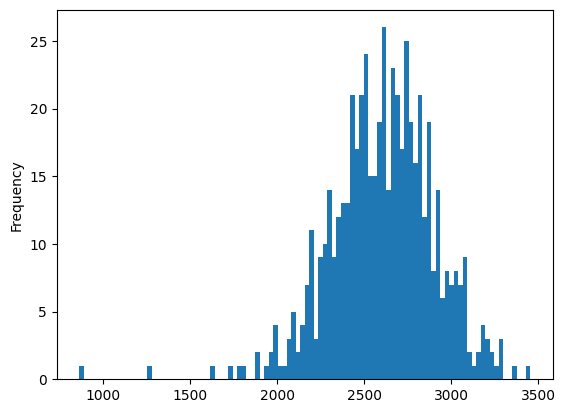

In [51]:
X.groupby('episode_id').n_tokens.sum().plot.hist(bins=100)

In [52]:
X.groupby('episode_id').n_tokens.sum().describe()

count     564.00000
mean     2606.98227
std       296.87365
min       864.00000
25%      2428.75000
50%      2619.50000
75%      2802.25000
max      3454.00000
Name: n_tokens, dtype: float64

#### Análise:

A partir do histograma, observa-se que os resultados obtidos para tokens médios e máximos por episódio e temporada estão de acordo com o disposto pelos dados. Ainda é possível observar na análise e pela tabela acima que temos uma distribuição que se aproxima de uma normal, concetrada próxima de sua média, contudo com uma assimetria a esquerda que pode ser observada tanto pelo histograma quanto pelo valor de sua média que é menor que a mediana.

### Parte 2

In [56]:
cols = ['episode_id', 'episode_season','episode_original_air_date', 'episode_imdb_rating', 
        'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']
episode_stats = data[cols].drop_duplicates()
episode_stats.to_csv('./data/theSimpsons/series_data.csv', sep=';', index=None)

In [ ]:
prompt_chain_1 = """

You are a data scientist specialized in analysing entertainment content. You are working on the
"The Simpsons" dataset, investigating patterns in the series series_data.

The data provided has the following columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

You want to evaluate the the relationship between IMDB ratings ('episode_imdb_rating', 'episode_imdb_votes') 
and episode audience ('episode_us_viewers_in_millions', 'episode_views')


Please, generate a list of 2 analyses that can be implemented given the available series_data, as a JSON file:
{[
    {'Name':'analysis name',
     'Objective': 'what we need to analyze',
     'Method': 'how we analyze it'
    }
]
}

Please return only the JSON file with the analysis list, without any additional information, 
including the JSON tag like this ```json. .

"""

In [58]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt_chain_1)
print(response.text)

[
    {
        "Name": "Correlation Analysis between IMDB Ratings and Viewership",
        "Objective": "To determine the relationship between IMDB ratings (rating and votes) and episode viewership (US viewers and total views).",
        "Method": "Calculate Pearson correlation coefficients between 'episode_imdb_rating', 'episode_imdb_votes' and 'episode_us_viewers_in_millions', 'episode_views'. Visualize the relationships using scatter plots and potentially a correlation matrix."
    },
    {
        "Name": "Comparative Analysis of Viewership for High vs. Low Rated Episodes",
        "Objective": "To compare the viewership metrics for episodes with high IMDB ratings versus episodes with low IMDB ratings.",
        "Method": "Divide the episodes into groups based on IMDB rating (e.g., top 25% vs. bottom 25%). Compare the average 'episode_us_viewers_in_millions' and 'episode_views' for the two groups. Perform a statistical test (e.g., t-test) to determine if the difference in viewersh

In [59]:
analysis = json.loads(response.text)
analysis

[{'Name': 'Correlation Analysis between IMDB Ratings and Viewership',
  'Objective': 'To determine the relationship between IMDB ratings (rating and votes) and episode viewership (US viewers and total views).',
  'Method': "Calculate Pearson correlation coefficients between 'episode_imdb_rating', 'episode_imdb_votes' and 'episode_us_viewers_in_millions', 'episode_views'. Visualize the relationships using scatter plots and potentially a correlation matrix."},
 {'Name': 'Comparative Analysis of Viewership for High vs. Low Rated Episodes',
  'Objective': 'To compare the viewership metrics for episodes with high IMDB ratings versus episodes with low IMDB ratings.',
  'Method': "Divide the episodes into groups based on IMDB rating (e.g., top 25% vs. bottom 25%). Compare the average 'episode_us_viewers_in_millions' and 'episode_views' for the two groups. Perform a statistical test (e.g., t-test) to determine if the difference in viewership is statistically significant. Visualize the comparis

In [ ]:
prompt_chain_2 = f"""

You are a data scientist specialized in analysing entertainment content. You are working on the
"The Simpsons" dataset, investigating patterns in the series series_data.

The data provided has the following columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Please implement the analysis below in python code:
{analysis[0]}

Please return only the code without any tags linke ```python and any explanations.
"""

genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt_chain_1)
print(response.text)

clean_code = response.text.replace("```python\n",'').replace("\n```",'')


```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_analysis(df):
    correlations = df[['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(df['episode_imdb_rating'], df['episode_us_viewers_in_millions'])
    plt.title('IMDB Rating vs. US Viewers')
    plt.xlabel('IMDB Rating')
    plt.ylabel('US Viewers (Millions)')


    plt.subplot(1, 2, 2)
    plt.scatter(df['episode_imdb_rating'], df['episode_views'])
    plt.title('IMDB Rating vs. Total Views')
    plt.xlabel('IMDB Rating')
    plt.ylabel('Total Views')
    plt.show()
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(df['episode_imdb_votes'], df['episode_us_viewers_in

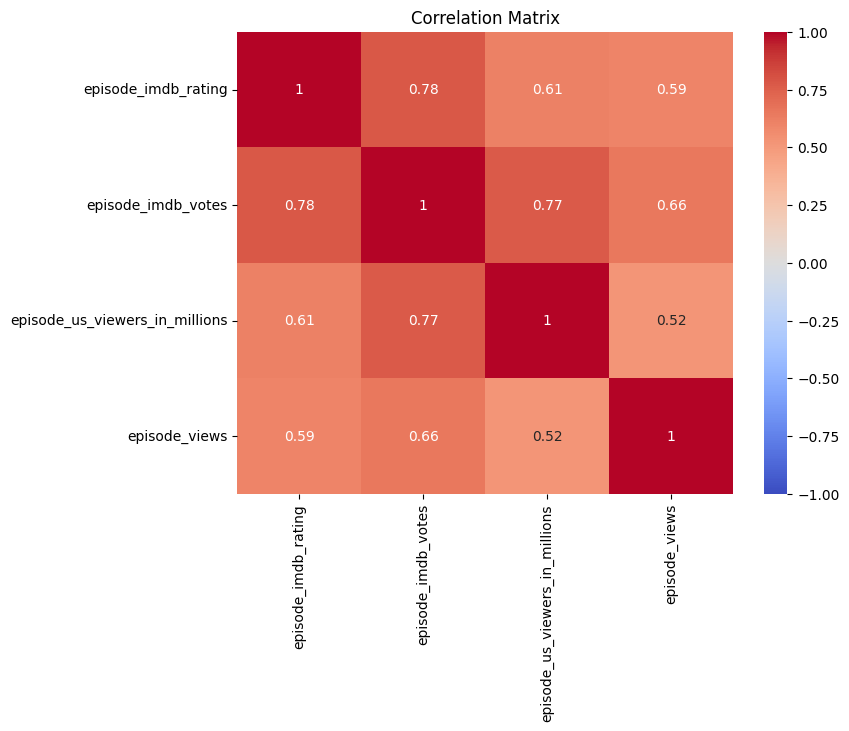

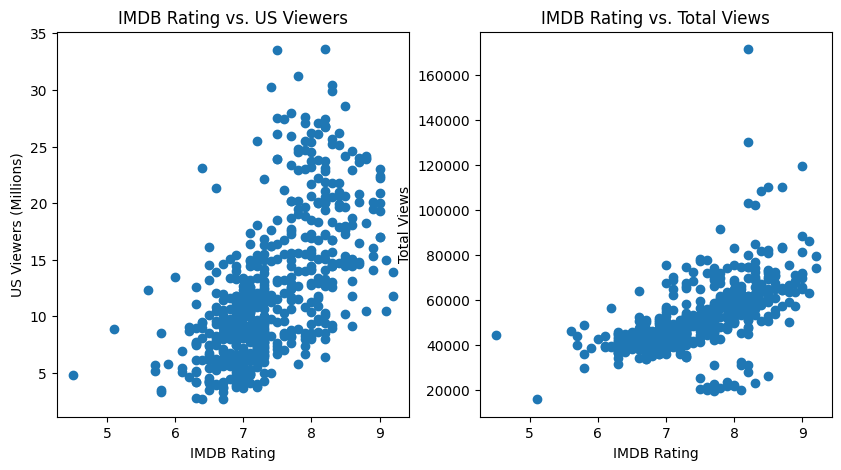

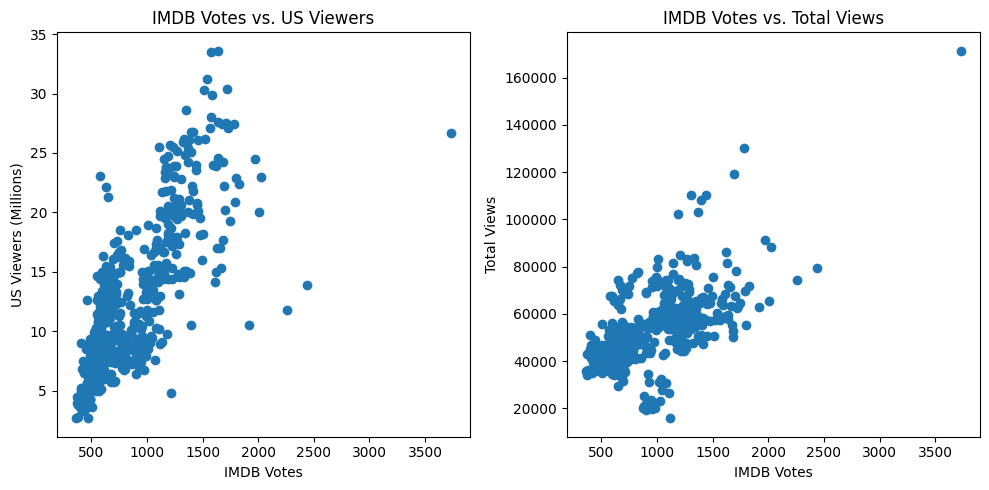

,episode_imdb_rating,episode_imdb_votes,episode_us_viewers_in_millions,episode_views
episode_imdb_rating,1.000000,0.780556,0.610862,0.594384
episode_imdb_votes,0.780556,1.000000,0.768896,0.655752
episode_us_viewers_in_millions,0.610862,0.768896,1.000000,0.516846
episode_views,0.594384,0.655752,0.516846,1.000000


In [ ]:
exec(clean_code)
correlation_analysis(episode_stats)

####   Justificativa dos Prompts

De forma a aproveitar o prompt chaining dividimos a tarefa de realizar uma análise descritivcas das avaliações em duas tarefas. A primeira foi responsável por passar o role, a estrutura dos dados e solicitar a criação de análise que identificasse a relação entre os ratings e a audiência. No segundo prompt solicitamos que a partir das análises criadas, o LLM retornasse os códigos Python para que pudessem ser executados.

## Questão 6

### 6.1

In [81]:
data['spoken_words'].sample(30)

92016                                               ...ead.
54647     John Travolta flew me in his jet. Now I have t...
130053             Fine. Fur's murder. Everything's murder.
76582                            Heh, heh, they're trapped.
47560                           No, that was not the thing.
140335                                                  NaN
152826    What! You did! Well, that's just... oh, what a...
104688                          Allow me to demonstri-care.
46688                                                   NaN
100447    Dad, he's not the real Santa. We can't afford ...
110498                Homer? It's your old roommate, Grady.
36388                                          No, I'm not.
141944                                   But our cushion...
136456    What? What? You're interesting. Why would you ...
8336                                                    NaN
148327                 Dad, that's my fourth grade teacher!
36543     Yes, for a minimal franchise f

In [82]:
positivas = [
    "that life is worth living",
    "i am the champions i am the champions no time for losers cause i am the champions of the worlllld",
    "eh you must be bart simpson well you look like youve got a strong young back"
    "Dad, it's not a private school. It's free"
    "Oh, that does sound fun"
]

negativas = [
    "i dont think theres anything left to say",
    "we came to this retreat because i thought our marriage was in trouble but i never for a minute thought it was in this much trouble homer how can you expect me to believe",
    "oh thats my brother asa he was killed in the great war held a grenade too long"
    "That's horrible. How could you, Dad?"
    "Not so fast, Simpson. This foul business was a"
]

neutras = [
    "wheres mr bergstrom",
    "would you have to do extra work",
    "oh please dad i want this more than anything in the world"
    "The hometown show's the big one, Homer."
    "Allow me to demonstri-care!"
]

In [83]:
episode_season = 5
episode_id = 92
Y = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
Y = Y.dropna(subset='normalized_text')

In [115]:
few_shot_prompt = f"""   
### Instructions:
You are an expert in human communication and marketing, specialized in sentiment analysis.
You have to classify lines from the simpsons show as negative, neutral and positive as defined below:

- positive: happy, constructive, hopefull, joy and similar lines.
- negative: sad, destructive, hopeless, angressive and similar lines.
- neutral: indifferent, objetive, formal and lines classified neigher as positive or negative.

### Examples:
Some pre-classified lines from this show are listed here:

#### Positive:
{'\n - '.join(positivas)}

#### Neutral:
{'\n - '.join(neutras)}

#### Negative:
{'\n - '.join(negativas)}

Given this information, respond in JSON with the classification of these other lines as positive, 
negative or neutral. The response should contain only the json with the classification, without any ''
additional information like json tag in the format of ```json

### Lines:

{ '\n - '.join(Y.normalized_text.tolist()) }


"""

In [117]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
total_tokens = model.count_tokens('\n - '.join(Y.normalized_text.tolist()))
print(total_tokens)

total_tokens: 2986



In [118]:
response = model.generate_content(few_shot_prompt)
print(response.text)

```json
{
  "dad weve been robbed": "negative",
  "wake up dad wake up there was a burglar and he took my saxophone": "negative",
  "woo hoo": "positive",
  "and our portable tv": "negative",
  "and my necklace": "negative",
  "eh thats no big loss": "neutral",
  "homer that necklace was a priceless bouvier family heirloom": "negative",
  "oh youve probably got a whole drawer full of em": "neutral",
  "well yes i do but theyre all heirlooms too": "neutral",
  "the burglar even took my stamp collection": "negative",
  "you had a stamp collection": "neutral",
  "stamp collection haw haw": "negative",
  "barts pain is funny but mine isnt that saxophone was my one creative outlet it was the only way i could truly express myself": "negative",
  "shhh quiet lisa": "neutral",
  "hey the burglar left his calling card": "neutral",
  "you have just been robbed by the springfield cat burglar cute": "negative",
  "hidilly ho neighboreenos": "neutral",
  "cant talk robbed go hell": "negative",
  "y

In [126]:
clean_response= response.text.replace("```json\n",'').replace("\n```",'')
classification = json.loads(clean_response)

classification_df = pd.DataFrame(list(classification.items()), columns=['Text', 'Sentiment'])
classification_df

,Text,Sentiment
0,dad weve been robbed,negative
1,wake up dad wake up there was a burglar and he...,negative
2,woo hoo,positive
3,and our portable tv,negative
4,and my necklace,negative
...,...,...
233,keep digging were bound to find something,positive
234,hmmm i guess were not gonna find anything,negative
235,uh howre we gonna get outta here,neutral
236,well dig our way out,neutral


### 6.2

In [130]:
classification_df['Sentiment'].value_counts(normalize=True)    

Sentiment
neutral     0.449580
negative    0.365546
positive    0.184874
Name: proportion, dtype: float64

### 6.3

In [136]:
positive =  classification_df[classification_df['Sentiment'] == 'positive'].sample(5, random_state=23)
positive

,Text,Sentiment
207,awwwww,positive
205,thank you and thank you dad you got it back ju...,positive
172,oh my i had no idea how much this town loved t...,positive
191,hooray,positive
78,and a fine job ye did too,positive


In [137]:
negative =  classification_df[classification_df['Sentiment'] == 'negative'].sample(5, random_state=23)
negative

,Text,Sentiment
115,you better have a good reason for doing that boy,negative
4,and my necklace,negative
127,homer wasnt the whole point to catch the cat b...,negative
234,hmmm i guess were not gonna find anything,negative
76,sorry dad youre too old,negative


In [138]:
neutral =  classification_df[classification_df['Sentiment'] == 'neutral'].sample(5, random_state=23)
neutral

,Text,Sentiment
190,to the retirement home,neutral
118,yep its on here,neutral
107,its hammer,neutral
217,its buried right here in springfield under a b...,neutral
192,and there she is the worlds largest cubic zirc...,neutral


### 6.4

In [140]:
positive_precision = 5/5
positive_precision

1.0

In [141]:
negative_precision = 4/(4+1)
negative_precision

0.8

In [142]:
neutral_precision = 4/(4+1)
neutral_precision

0.8

### Respostas

1. Foi necessária somente uma chamada uma vez que a contagem de tokens foi inferior ao limite do modelo conforme documentação em [Gemini 1.5 Pro Doc](https://ai.google.dev/pricing#1_5pro)

2.  A distribuição de fala por categoria foi: Neutra 44,95%, Negativa 36,55% e Positiva 18,48%

3. Com relação a acurácia, identificamos uma acurácia de 100% para as positivas e de 80% para as negativas e neutras.

4. As precisões foram 100% para a classe positiva e 80% para as classes negativas e neutras



## Questão 7

In [ ]:
resumo = """"

UM ladrão se aproxuma da caso do Homer e abre a porta. O cachorro reage mas é iludido com uma salsicha. 
Homer também é iludido por uma salsicha.
O ladrão rouba vários objetos da casa e vai embora, saxofone, colar, coleção de selos e tv portátil.
Todos na casa reclamam do roubo.
O ladrão deixou um cartão  dizendo que você foi roubado pelo gatuno de springfield.
Diversas pessoas foram roubadas na cidade.
Homer liga para a polícia para reportar o roubo.
Os roubos são noticiados na tv.
A polícia encontra o lenço do ladrão em uma das casas

As pessoas da cidade começam a se proteger contratando sistemas de segurança para suas casas.
O pai do Homer se assusta com um colega achando que era um ladrão
Homer conversa com a família sobre as novas regras de seguranca
Homer da um vaso para Lisa em substituicao ao saxesofone roubado
O ladrão ataca novamente.
Os cidadãos se reúnem para que o Flanders lidere a segurança da cidade.
Os cidadãos escolhem o Homer para a tarefa também uma vez que ele é muito impulsivo.
Pai do Homer quer participar também mas é rejeitado por estar muito velho.
Os cidadão se armam e criam códigos para se comunicarem.

Homer busca comprar mais armas para a segurança da cidade.
Homer empresta um megafone de bart e passa a patruhar a cidade impondo um toque de recolher e regras de segurança
com certa truculência.
Homer conta a familia durante o jantar sobre a patrulha.
Lisa questiona quem vigia os vigilantes e quais os resultados obtidos.
Homer é questionado por um jornalista sobre as ações dos vigilantes e responde que as estatísticas mentem.
O programa do jornalista recebe uma ligação do gatuno de springfield que desafia Homer.
O ladrão afirma que irá assaltar o museu de springfield e homer diz que irá protegê-lo

Homer e seus vigilantes se posicionam para proteger o museu.
Homer fica aguardando o ladrão no museu mas sai para impedir criancas de beberem cervejas.
O ladrão chega e entra no museu, desliga o alarme e rouba um zircónio (diamante).
A população da cidade critica e humilha Homer por não ter protegido o museu.
O pai do Homer chega na casa do simpsons e diz que sabe quem é o ladrão.
Pai do Homer diz que o ladrão mora no retiro dos idosos e chama-se Molloys.
Pai do Homer diz que suspeito do ladrão por causa dos tenis e do modo de andar e que ele tem um zircónio.
A população de springfield vai até o retiro e encontra o zircónio.
Homer agradece o pai e diz que ele é um herói.





"""

In [167]:
len(resumo.split())

362